# Исследование объявлений о продаже квартир

___Описание проекта___:

Получен архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

___Описание данных___:


- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении


## Изучение данных из файла

### Импорт библиотек и открытие файла

In [1]:
#импортирую бибилиотеки
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn

In [2]:
warnings.filterwarnings('ignore')
#загружаю датасет
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

___Вывод___:

- В данных пристуствуют пропущенные значения.
- Фоматы некоторых столбцов некорректны

## Предобработка данных

### Заполнение пропусков

Посмотрим на корреляцию жилой площади и площади кухни от количества комнат. Для сравнения также посмотрим корреляцию общей площади от общего количества этажей в доме:

In [3]:
print('Корреляция количества комнат и жилой площади:', df['rooms'].corr(df['living_area']))
print('Корреляция количества комнат и площади кухни:', df['rooms'].corr(df['kitchen_area']))

Корреляция количества комнат и жилой площади: 0.8459774567888746
Корреляция количества комнат и площади кухни: 0.26994485416385783


Жилая плащадь сильно коррелирует с количеством комнат, поэтому заполним пропущенные данные по жилой площади в зависимости от количества комнат.
Площадь кухни не сильно коррелирует с количеством комнат, поэтому заполним лощадь кухни общей медианой.

In [4]:
df['balcony'] = df['balcony'].fillna(0) 
df['is_apartment'] = df['is_apartment'].fillna(False)
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median())
df.loc[df['studio']==True, 'kitchen_area'] = 0
df['kitchen_area'] = df['kitchen_area'].fillna(df['kitchen_area'].median())
#df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].median())
df = df.dropna(subset=['locality_name'], axis=0).reset_index()

# это цикл для удаления неявных дублей в названияя населенных пунктов
for name in ['поселок ', 'деревня ', 'посёлок ', 'городского ', 'типа ', 'село ', 'коттеджный ', 'станции ']:
             df['locality_name'] = df['locality_name'].str.replace(name, '')

# это цикл для заполнения пропущенных значений жилой плащади, медианными значениями в зависимости от количества комнат        
for room in df['rooms'].unique():
    median_area_room = df.loc[df['rooms'] == room, 'living_area'].median()
    df.loc[(df['living_area'].isna())&(df['rooms'] == room), 'living_area'] = median_area_room
    

#это функция для заполнения значений медианой в зависимости от города
def fillna_group_median(column):
    for city in df['locality_name'].unique():
        median_city = df.loc[df['locality_name'] == city, column].median()
        df.loc[(df[column].isna())&(df['locality_name'] == city), column] = median_city
        median = df[column].median() # добавление общей медианы после просчета медианы с учетом городов, для того чтобы учитывать вес населенных пунктов
        df.loc[df[column].isna(), column] = median
        
        
#применяем функцию заполнения значений медиаой в зависимости от города         
fillna_group_median('airports_nearest')
fillna_group_median('parks_around3000')
fillna_group_median('parks_nearest')
fillna_group_median('ponds_around3000')
fillna_group_median('ponds_nearest')
fillna_group_median('cityCenters_nearest')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 23 columns):
index                   23650 non-null int64
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null object
rooms                   23650 non-null int64
ceiling_height          14490 non-null float64
floors_total            23650 non-null float64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null float64
locality_name           23650 non-null object
airports_nearest        23650 non-null float64
cityCenters_nearest     23650 non-null float64
parks_around3000        23650 non-null float64
parks_nearest    

Заполним пропущенные данные высоты потолков, медианой в зависимости от расстояния до центра и расстояния до ближайшего парка(так мы заполним пропущенные значения высоты потолков, миданой значений высоты потолков в том же доме):

In [5]:
print('Пропуски до:', df['ceiling_height'].isna().sum())

#датафрейм со сгруппиованными значениями
medians = (df.groupby(['cityCenters_nearest', 'parks_nearest'])
          .agg({'ceiling_height':'median'}).rename(columns = {'ceiling_height': 'median_ceiling_height'}))
# пристегиваем датафрейм с медианами к исходному датафрейму
df = df.merge(medians, on = ['cityCenters_nearest', 'parks_nearest'])

#там где высота потолков не заполнена, заполняем значениями из столца с медианой
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df.loc[df['ceiling_height'].isna(), 'median_ceiling_height']

#удаляем столбец из кторого перенесли значения медианы
df = df.drop(columns='median_ceiling_height')

print('Пропуски после:', df['ceiling_height'].isna().sum())

Пропуски до: 9160
Пропуски после: 2689


После заолнения высоты потолков по значения медианы в зависимости от конкретного дома, осалась не заполнена 1/3 значений. Вероятно это объявения из домов в которых представлено только 1 объявление. Заполним эти пропущенные значения общей медианой по всем домам:

In [6]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
print('Пропуски после:', df['ceiling_height'].isna().sum())

Пропуски после: 0


Переводим столбец first_day_exposition в формат даты и смотрим зависимость незаполненных значений от даты публикации

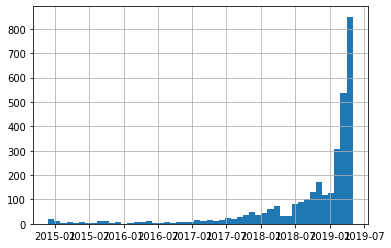

In [7]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT')
df_days_exposition_na = df[df['days_exposition'].isna()]
df_days_exposition_na['first_day_exposition'].hist(bins=50)

Из графика видно что данные с пропущенным значением количества дней от даты публикации до снятия с публикации, рстет от начала изучаемого периода к последнму зафиксированному дню изучаемго периода. Вероятно это связано с тем что на момент выгрузки данных, часть объявлений еще были активны.
Так как в данном анализе рассматриваются цены на момент снятия публикации и этот параметр являеться ключевым, строки с объявлениями не снятыми с публикации, удаляем.

In [8]:
df = df.dropna(subset=['days_exposition'], axis=0).reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20470 entries, 0 to 20469
Data columns (total 24 columns):
level_0                 20470 non-null int64
index                   20470 non-null int64
total_images            20470 non-null int64
last_price              20470 non-null float64
total_area              20470 non-null float64
first_day_exposition    20470 non-null datetime64[ns]
rooms                   20470 non-null int64
ceiling_height          20470 non-null float64
floors_total            20470 non-null float64
living_area             20470 non-null float64
floor                   20470 non-null int64
is_apartment            20470 non-null bool
studio                  20470 non-null bool
open_plan               20470 non-null bool
kitchen_area            20470 non-null float64
balcony                 20470 non-null float64
locality_name           20470 non-null object
airports_nearest        20470 non-null float64
cityCenters_nearest     20470 non-null float64
parks_aroun

### Изменение типа данных в столбцах

In [9]:
#переводим в соответствующий тип данных значения столбцов
df['floors_total'] = df['floors_total'].astype('int')
df['balcony'] = df['balcony'].astype('int')
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
df['days_exposition'] = df['days_exposition'].astype('int')


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20470 entries, 0 to 20469
Data columns (total 24 columns):
level_0                 20470 non-null int64
index                   20470 non-null int64
total_images            20470 non-null int64
last_price              20470 non-null float64
total_area              20470 non-null float64
first_day_exposition    20470 non-null datetime64[ns]
rooms                   20470 non-null int64
ceiling_height          20470 non-null float64
floors_total            20470 non-null int64
living_area             20470 non-null float64
floor                   20470 non-null int64
is_apartment            20470 non-null bool
studio                  20470 non-null bool
open_plan               20470 non-null bool
kitchen_area            20470 non-null float64
balcony                 20470 non-null int64
locality_name           20470 non-null object
airports_nearest        20470 non-null float64
cityCenters_nearest     20470 non-null float64
parks_around300

### Вывод
в данных были пропущенные значения:
- ceiling_height / высота потолков - вероятно эти данные некоторые продавцы считают незначительными в случаях когда высота стандартная. Замним значение на медиану
- is_apartment / апартаменты (булев тип) - аппартаменты особый тип недвижимости, поэтому владельцы аппартаментов должны хоошо знать что это. Пропуски вероятно делали те у кого недвижимость не аппартаменты. Заколним пропуски значением False
- living_area / жилая площадь в квадратных метрах (м²) - эти данные являются одними из самых важных при продаже и покупке жилья, вероятно пропуски появились по невнимательности продавцов. Верояно стоит обратиться к разработчикам что бы они сделали заполнение этого пункта обязательным. Заполним значения медианой
- floors_total / всего этажей в доме - вероятно значения не заполнены по невнимательности или из за оценки этого параметра продавцами как малозначительного. Заменим значения медианой
- balcony / число балконов - отсутствие значений вероятно говорит о том что в кваритере нет балконов. Заменим значения на "0"
- kitchen_area / площадь кухни в квадратных метрах (м²) - для всех студий усановим значение "0", оставшиеся пропуски заменим медианой
- locality_name / название населённого пункта - пропущено не значительное количество строк(0,2%). Удаляем строки с пропущенными значениями. Убираем упоминание типа поседения, так как нас интересует сравнение Санкт-Петербург/не Санкт-Петербург
- total_area / площадь квартиры в квадратных метрах (м²) - заполним пропущенные значения меианой в зависимости от количества комнат
- airports_nearest, airports_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, cityCenters_nearest - это данные которые зависят от местоположения объекта недвижимости, заполним пропущенные значения в зависимости от названия населенного пункта

Переводим в соответствующий тип данных значения столбцов:
- Округляем до целых там где это возможно
- Переводим в формат даты колонку с датой



## Расчёты и добавление результатов в таблицу

### Добавляем столбец с ценой квадратного метра:

In [10]:
df['square_prise'] = df['last_price'] / df['total_area'] 
df.head()

,level_0,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_prise
0,1,1402,10,9000000.0,110.0,2017-04-29,3,2.70,16,53.000,...,1,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,223,81818.181818
1,2,9111,9,8000000.0,70.0,2016-06-21,2,2.75,17,37.000,...,5,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,93,114285.714286
2,3,11843,20,16500000.0,109.0,2017-01-19,3,2.80,16,72.000,...,4,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,369,151376.146789
3,4,15596,2,3500000.0,43.9,2018-10-19,1,2.70,16,18.200,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,41,79726.651481
4,6,17230,2,19327000.0,175.7,2017-12-06,5,2.70,16,91.785,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,11,110000.000000


### Добавляем столбец с днем недели, месяцем и годом публикации:

In [11]:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
df.head()

,level_0,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_prise,weekday,month,year
0,1,1402,10,9000000.0,110.0,2017-04-29,3,2.70,16,53.000,...,16028.0,1,482.0,2,755.0,223,81818.181818,5,4,2017
1,2,9111,9,8000000.0,70.0,2016-06-21,2,2.75,17,37.000,...,16028.0,1,482.0,2,755.0,93,114285.714286,1,6,2016
2,3,11843,20,16500000.0,109.0,2017-01-19,3,2.80,16,72.000,...,16028.0,1,482.0,2,755.0,369,151376.146789,3,1,2017
3,4,15596,2,3500000.0,43.9,2018-10-19,1,2.70,16,18.200,...,16028.0,1,482.0,2,755.0,41,79726.651481,4,10,2018
4,6,17230,2,19327000.0,175.7,2017-12-06,5,2.70,16,91.785,...,16028.0,1,482.0,2,755.0,11,110000.000000,2,12,2017


### Добавляем категорию этажа (первый, последний, другой):

In [12]:
def froor_grouping(row_values):
    if row_values['floor'] == 1: return 'первый'
    if row_values['floor'] == row_values['floors_total']: return 'последний'
    return 'другой'
df['floor_group'] = df.apply(froor_grouping, axis = 1)
df.groupby('floor_group')['ponds_nearest'].count()

floor_group
другой       15188
первый        2465
последний     2817
Name: ponds_nearest, dtype: int64

### Добавляем соотношения площадей жилая/общая, кухня/общая

In [13]:
df['living_total'] = df['living_area'] / df['total_area']
df['kitchen_total'] = df['kitchen_area'] / df['total_area']
df.head()

,level_0,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,...,ponds_around3000,ponds_nearest,days_exposition,square_prise,weekday,month,year,floor_group,living_total,kitchen_total
0,1,1402,10,9000000.0,110.0,2017-04-29,3,2.70,16,53.000,...,2,755.0,223,81818.181818,5,4,2017,другой,0.481818,0.186364
1,2,9111,9,8000000.0,70.0,2016-06-21,2,2.75,17,37.000,...,2,755.0,93,114285.714286,1,6,2016,другой,0.528571,0.171429
2,3,11843,20,16500000.0,109.0,2017-01-19,3,2.80,16,72.000,...,2,755.0,369,151376.146789,3,1,2017,другой,0.660550,0.183486
3,4,15596,2,3500000.0,43.9,2018-10-19,1,2.70,16,18.200,...,2,755.0,41,79726.651481,4,10,2018,первый,0.414579,0.264237
4,6,17230,2,19327000.0,175.7,2017-12-06,5,2.70,16,91.785,...,2,755.0,11,110000.000000,2,12,2017,первый,0.522396,0.051281


## Исследовательский анализ данных

#### Гистограмма общих площадей квартир

In [14]:
# делаем функцию для построения диаграм
def plot_hist(column, count_bins, title):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    if q1-2*iqr <= 0:
        xlim = 0
    else:
        xlim = q1-2*iqr
    df[column].plot(kind='hist', bins=count_bins, grid=True, range=(xlim,q3+2*iqr), title=title)

Text(0.5, 0, 'м2')

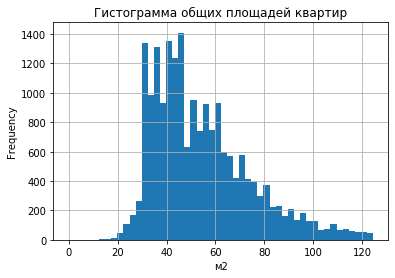

In [15]:
plot_hist('total_area', 50, 'Гистограмма общих площадей квартир')
plt.xlabel('м2')

Чаще всего продают квартиры 30-50 кв.м. 

#### Гистограмма цен на жилье

Text(0.5, 0, 'руб')

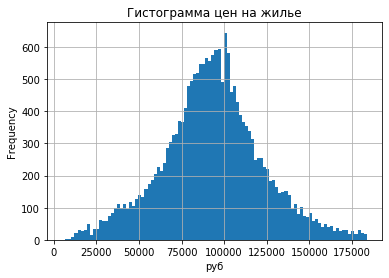

In [16]:
plot_hist('square_prise', 100, 'Гистограмма цен на жилье')
plt.xlabel('руб')

Чаще всго продают квартиры за 90-100 тыс.руб/кв.м.



### Гистограмма количества комнат:

Text(0.5, 0, 'сколько комнат')

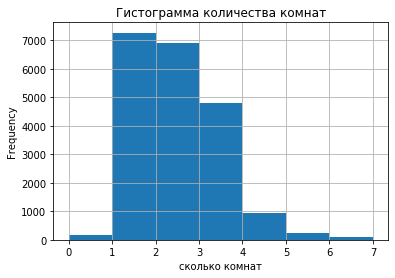

In [17]:
plot_hist('rooms', 7, 'Гистограмма количества комнат')
plt.xlabel('сколько комнат')

В основном продают 2-4 комнатные квартиры


#### Гистограмма высоты потолков:

Text(0.5, 0, 'м')

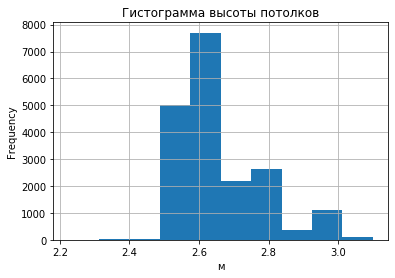

In [18]:
plot_hist('ceiling_height', 10, 'Гистограмма высоты потолков')
plt.xlabel('м')

Чаще всего продают квартиры выостой 2,6м

#### Гистограма времени продажи квартиры:

Медиана времени продажи квартиры: 95.0
Срднее время продажи квартиры: 180.7531998045921


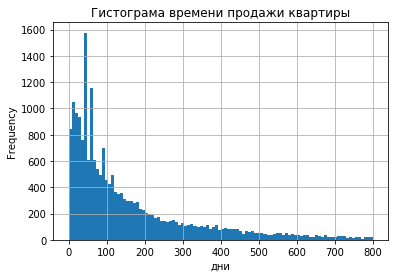

In [19]:
df['days_exposition'].plot(kind='hist', bins=100, grid=True,  range=(0,800), title='Гистограма времени продажи квартиры')
plt.xlabel('дни')
print('Медиана времени продажи квартиры:', df['days_exposition'].median())
print('Срднее время продажи квартиры:', df['days_exposition'].mean())

Обычно время продажи квартиры от выставления, до снятия объявления составляет 95 дней.

В Санкт-Птербурге и областе, для оъявлений в Яндекс Недвижимости, размещение платное. Оплачиваются периоды в 30 дней. Поэтому наблюдаются значительные изменения на графике в периоды кратные 30 дням или близкие к ним(вероятно пользователи вспоминают или за несколько дней до окнчания подписки или в течении нескольких дней после уведомления о списании средств за продвижение)

Гистограмма приближается к минимальному значению на уровне 500 дней, поэтому можно говорить о том что продажа дольше 500 дней это необычно долго.

Посмотрим как распределяется гистограмма времени продажи квартиры в первые 14 дней:

Text(0.5, 0, 'дни')

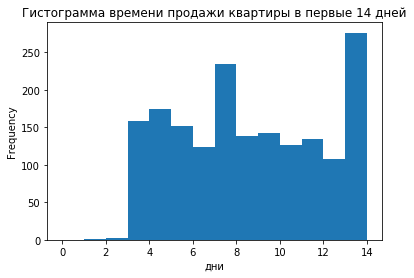

In [20]:
df['days_exposition'].plot( kind='hist', bins=14, range=(0,14), title='Гистограмма времени продажи квартиры в первые 14 дней')
plt.xlabel('дни')

В первые 3 суток, продаж практически нет, поэтому можно говорить о том что продажа в первые 3 суток это очень быстро.

То есть квартиры очень редко продают быстрее 3 суток. Также, редко продают квартиры дольше 500 дней.

### Редкие и выбивающиеся значения


### Удаялем выбросы для данных занесенных пользователями вручную:

In [21]:
filtred_df = df

def emissions_del(row, column):
    row[column].count()
    q1 = row[column].quantile(0.25)
    q3 = row[column].quantile(0.75)
    iqr = q3-q1
    print()
    print('Нижняя граница выбросов для',column,':',  q1 - 1.5*(q3-q1), 
          'Сейчас минимум:',row[column].min())
    print('Верхняя граница выбросов для',column,':', q3 + 1.5*(q3-q1), 
          'Сейчас максимум:',row[column].max())
    emissions_before = row[column].count()
    row = row[row[column] >= (q1-1.5*iqr)]
    row = row[row[column] <= (q3+1.5*iqr)]
    emissions_after = row[column].count() 
    print('Удалено выбросов:', emissions_before-emissions_after)
    return row

filtred_df = emissions_del(filtred_df, 'living_total')
filtred_df = emissions_del(filtred_df, 'kitchen_total')
filtred_df = emissions_del(filtred_df, 'square_prise')

#убираем слишком высокие и слишком низкие значения потолков
filtred_df = filtred_df.query('2.5 < ceiling_height < 6') 


Нижняя граница выбросов для living_total : 0.2660873251936601 Сейчас минимум: 0.02158273381294964
Верхняя граница выбросов для living_total : 0.8585294230656221 Сейчас максимум: 1.519047619047619
Удалено выбросов: 213

Нижняя граница выбросов для kitchen_total : -0.01478834107900584 Сейчас минимум: 0.0
Верхняя граница выбросов для kitchen_total : 0.3843832087290362 Сейчас максимум: 0.7878787878787878
Удалено выбросов: 310

Нижняя граница выбросов для square_prise : 22930.70123445276 Сейчас минимум: 111.8348623853211
Верхняя граница выбросов для square_prise : 164956.76778384857 Сейчас максимум: 1907500.0
Удалено выбросов: 907


Вывод: Больше всего выбросов в данных по стоимости квадратнго метра, меньше всего в данных по отношению жилой плащади к общей.

### Исследование факторов, влияющих на стоимость квартиры

#### Зависимость цены за квадратный метр от общей площади жилья:

Корреляция цены за квадратный метр от общей площади 0.06181105422193786


Text(0, 0.5, 'руб')

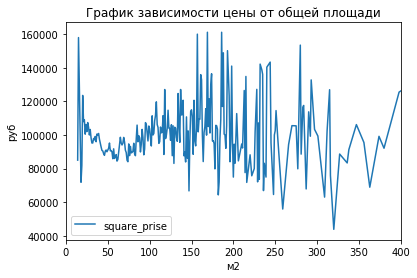

In [22]:
print('Корреляция цены за квадратный метр от общей площади', filtred_df['square_prise'].corr(filtred_df['total_area']))
filtred_df['total_area_round'] = filtred_df['total_area'].astype('int')
filtred_df.pivot_table(index='total_area_round', values='square_prise',aggfunc='median').plot(title='График зависимости цены от общей площади', xlim=(0,400))
plt.xlabel('м2')
plt.ylabel('руб')

Линейной зависимости цены от общей площади нет. При этом набюлюдается наблюдается большой разброс цен на жилье до 25 кв м. Цены на квдратный метр плавно нижаються с увеличением общей площади с 25 до 50 кв м, далее с 50 до 100кв м наблюдается плавный рост цен за кв м. Жилье плошадью более 100кв м, арактериуется максимальным разбросом цен.

#### Зависимость цены за квадратный метр от количества комнат:

In [23]:
print('Корреляция цены за квадратный метр от количества комнат', filtred_df['square_prise'].corr(filtred_df['rooms']))

Корреляция цены за квадратный метр от количества комнат -0.09817990569335855


Посмотрим на распределение количества жилья в зависимости от количества комнат:

In [24]:
filtred_df.pivot_table(index='rooms', values='square_prise', aggfunc='count')

,square_prise
rooms,
0,155
1,5654
2,5218
3,3622
4,701
5,194
6,57
7,26
8,8


Жилья с количеством комнат больее 7, мало, поэтому ограничим график семью комнатами:

Text(0, 0.5, 'руб')

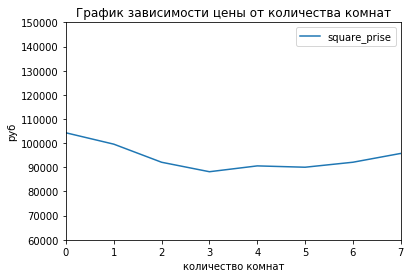

In [25]:
filtred_df.pivot_table(index='rooms', values='square_prise',aggfunc='median').plot(title='График зависимости цены от количества комнат', xlim=(0,7), ylim=(60000,150000))
plt.xlabel('количество комнат')
plt.ylabel('руб')

Из графика видно что стоиомсть квадратного метра жилья максимальная для студий и однокомнатных квартир. Дешевле стоит 2-7 комнатное жилье.

#### Зависимость цены за квадратный метр от расстояния до центра:

In [26]:
print('Корреляция цены за квадратный метр от расстояния до центра', filtred_df['square_prise'].corr(filtred_df['cityCenters_nearest']))

Корреляция цены за квадратный метр от расстояния до центра -0.2363017503858832


Text(0, 0.5, 'руб')

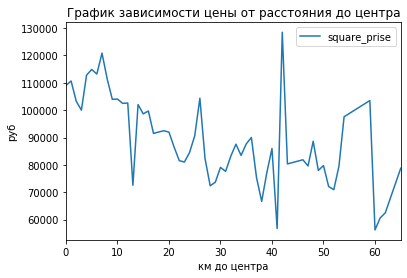

In [27]:
filtred_df['cityCenters_nearest_round'] = (filtred_df['cityCenters_nearest']/1000).astype('int')
filtred_df.pivot_table(index='cityCenters_nearest_round', values='square_prise',aggfunc='median').plot(title='График зависимости цены от расстояния до центра')
plt.xlabel('км до центра')
plt.ylabel('руб')

Прослеживается линейная зависимость цены на квадратный метр от удаленности от центра.

#### Тепловая карта корреляций всего датафрейма:

Text(0.5, 1, 'Тепловая карта корреляций')

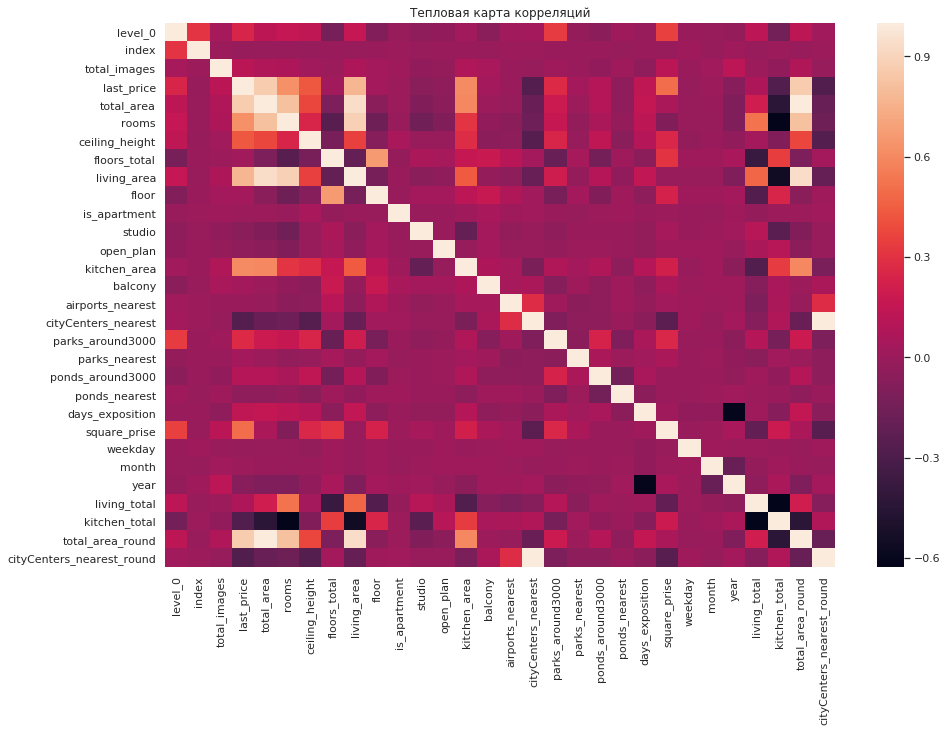

In [28]:
seaborn.set(rc = {'figure.figsize':(15,10)})
ax = plt.axes()
seaborn.heatmap(filtred_df.corr())
ax.set_title('Тепловая карта корреляций')

Зависимость цены за квадратный метр от этажа:

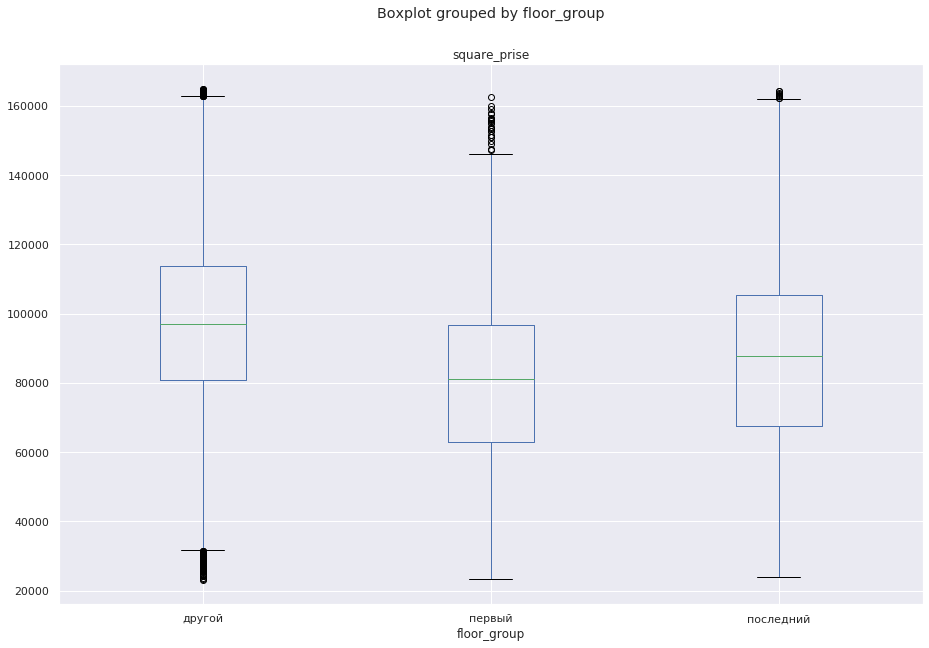

In [29]:
filtred_df.boxplot(column = 'square_prise', by = 'floor_group')

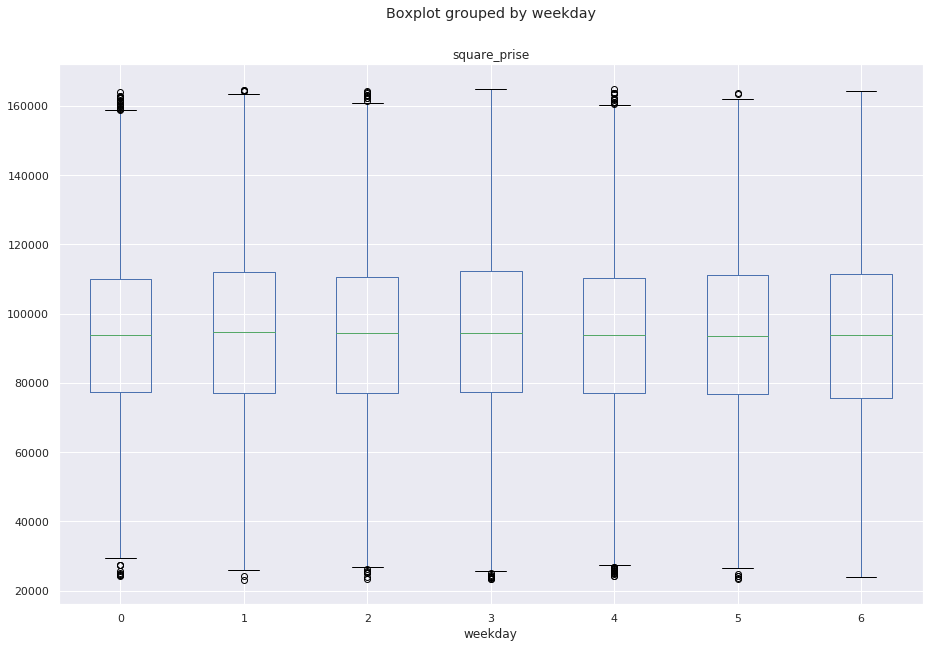

In [30]:
filtred_df.boxplot(column = 'square_prise', by = 'weekday')

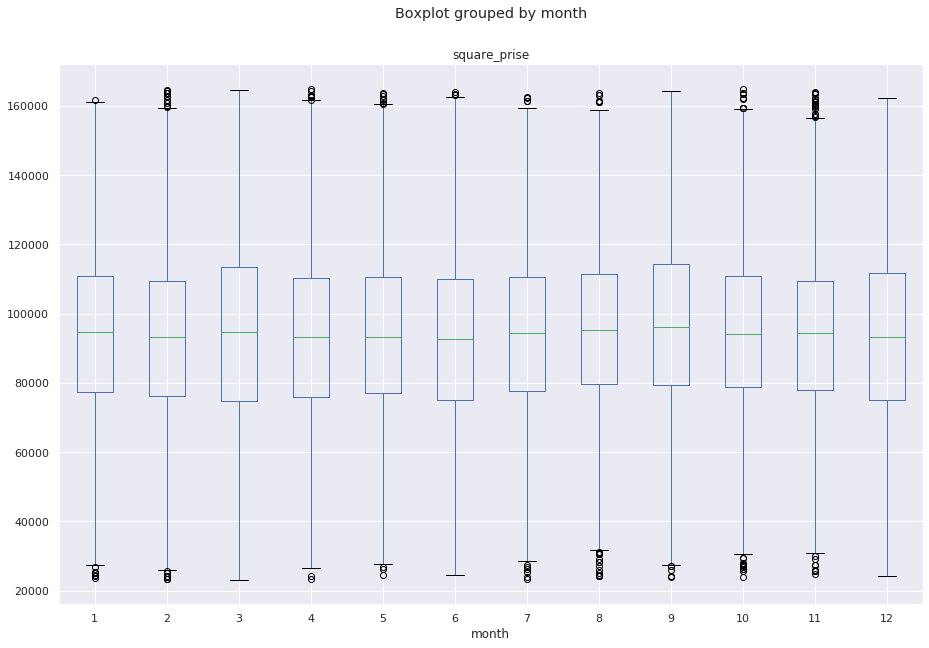

In [31]:
filtred_df.boxplot(column = 'square_prise', by = 'month')

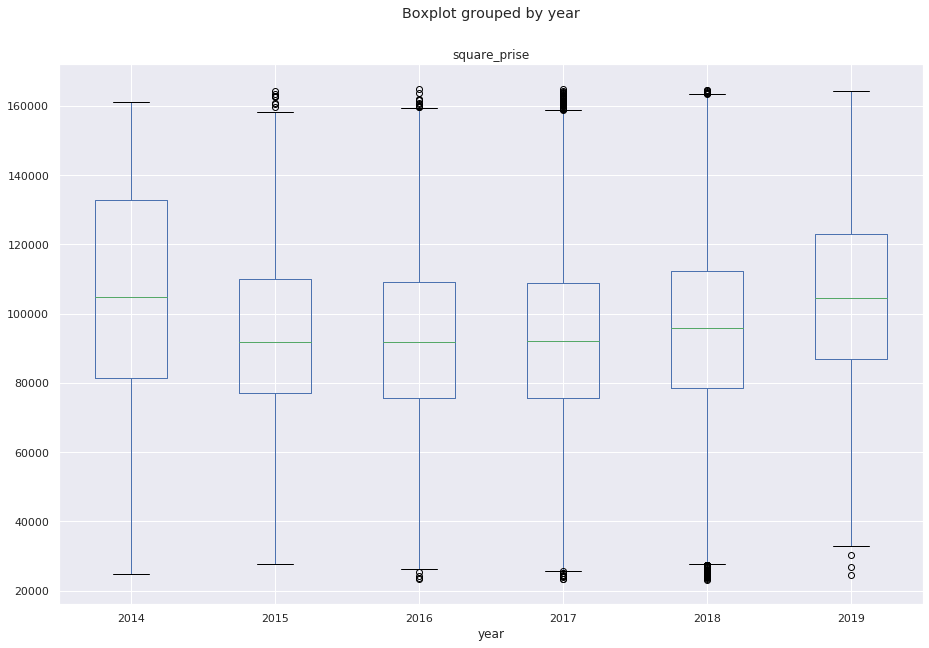

In [32]:
filtred_df.boxplot(column = 'square_prise', by = 'year')

Вывод: 

- На стоимость квадратного метра жилья почти не влияет количество комнат и общая площадь, но значительно влияет расстояние до центра.
- Дешевле всего продаются квартиры на первом этаже. На последнем этаже квартиры стоят дороже чем на первом. Самое дорогое жилье - жилье расположенное не на первом и не на последнем этажах.
- Дороже всего квартиры выставленные в середине недели.
- Дороже всего квартиры выствавленные весной и осенью.
- Стоимость жилья была самой высокой в 2014 году, затем произошо резкое подешевление с последующим ростом. С 2015 года жилье дорожало и в 2019 году пришло к уровню 2014 года.

### Зависимость цены от населенного пункта

Выделим 10 населенных пунктов с наибольшим количеством объявлений и отсортируем по убыванию медианы стоимости:

In [33]:
top10_filtred_df = filtred_df.pivot_table(index='locality_name', values='square_prise', aggfunc=['count', 'median'])
top10_filtred_df.columns = ['count', 'median']
top10_filtred_df = top10_filtred_df.sort_values('count', ascending=False).head(10)
top10_filtred_df.sort_values('median', ascending=False)

,count,median
locality_name,,
Санкт-Петербург,10363,102604.166667
Пушкин,219,99744.245524
Кудрово,415,94313.453537
Парголово,271,91516.560139
Мурино,512,85145.665323
Шушары,365,76125.000000
Колпино,195,74722.222222
Гатчина,201,67924.528302
Всеволожск,299,65833.333333


График зависимости цены от местоположения:

Text(0, 0.5, 'руб')

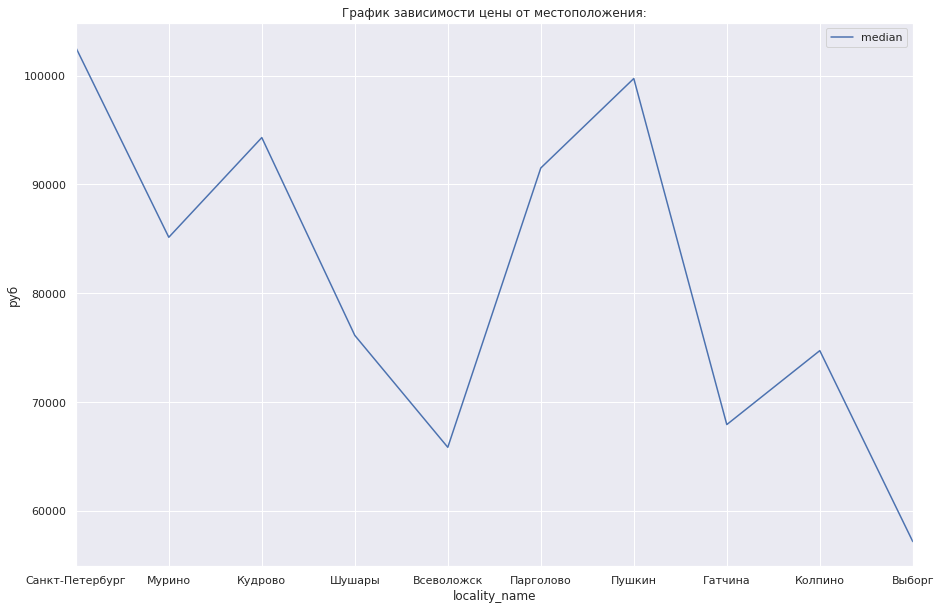

In [34]:
top10_filtred_df.plot(y='median', title='График зависимости цены от местоположения:')
plt.ylabel('руб')

Вывод: Самое дорогое жилье в Санкт-Петербурге. Самое дешевое, из самых попоулярных населенны пунктов, в Выборге.

### Как удаленность от центра влияет на стоимость. На примере СПб

Создаим столбец с расстоянием до центра, с округлением до целых километров:

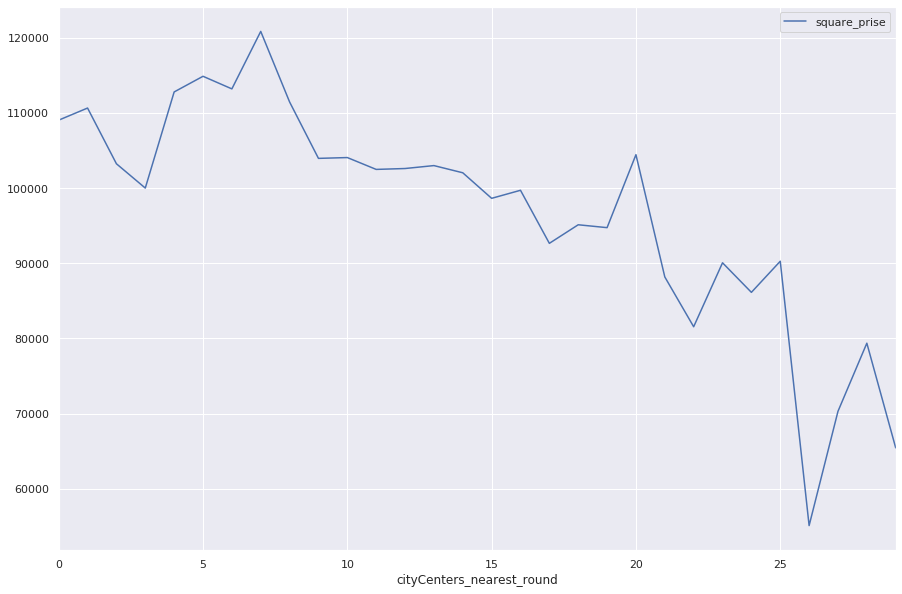

In [35]:
centre_df = filtred_df.query('locality_name == "Санкт-Петербург"')
centre_df.pivot_table(index='cityCenters_nearest_round', values='square_prise', aggfunc='median').astype('int').plot(grid=True, figsize=(15,10))

На отметке в 1км, график сильно меняется. Примем за центральный район, радиус в 1км от центра.

Возьмем срез жилья в центре Санкт-Петербурга:

In [36]:
centre_df = centre_df.query('cityCenters_nearest_round <= 1')
print('Жилья, в цетре, для анализа:', centre_df['cityCenters_nearest_round'].count())

Жилья, в цетре, для анализа: 186


Убираем выбросы:

In [37]:
def emissions_del(row, column):
    row[column].count()
    q1 = row[column].quantile(0.25)
    q3 = row[column].quantile(0.75)
    iqr = q3-q1
    print()
    print('Нижняя граница выбросов для',column,':',  q1 - 1.5*(q3-q1), 
          'Сейчас минимум:',row[column].min())
    print('Верхняя граница выбросов для',column,':', q3 + 1.5*(q3-q1), 
          'Сейчас максимум:',row[column].max())
    emissions_before = row[column].count()
    row = row[row[column] >= (q1-1.5*iqr)]
    row = row[row[column] <= (q3+1.5*iqr)]
    emissions_after = row[column].count() 
    print('Удалено выбросов:', emissions_before-emissions_after)
    return row


centre_df = emissions_del(centre_df, 'living_total')
centre_df = emissions_del(centre_df, 'kitchen_total')
centre_df = emissions_del(centre_df, 'square_prise')



Нижняя граница выбросов для living_total : 0.36699146065922394 Сейчас минимум: 0.3373493975903614
Верхняя граница выбросов для living_total : 0.8698290470494416 Сейчас максимум: 0.8484848484848485
Удалено выбросов: 1

Нижняя граница выбросов для kitchen_total : 0.007509193498582395 Сейчас минимум: 0.025380710659898477
Верхняя граница выбросов для kitchen_total : 0.2595935210397776 Сейчас максимум: 0.34935064935064936
Удалено выбросов: 13

Нижняя граница выбросов для square_prise : 46143.0543561298 Сейчас минимум: 57961.16504854369
Верхняя граница выбросов для square_prise : 176336.01612581793 Сейчас максимум: 164319.24882629106
Удалено выбросов: 0


### Гистограммы

#### Гистограмма общих площадей квартир

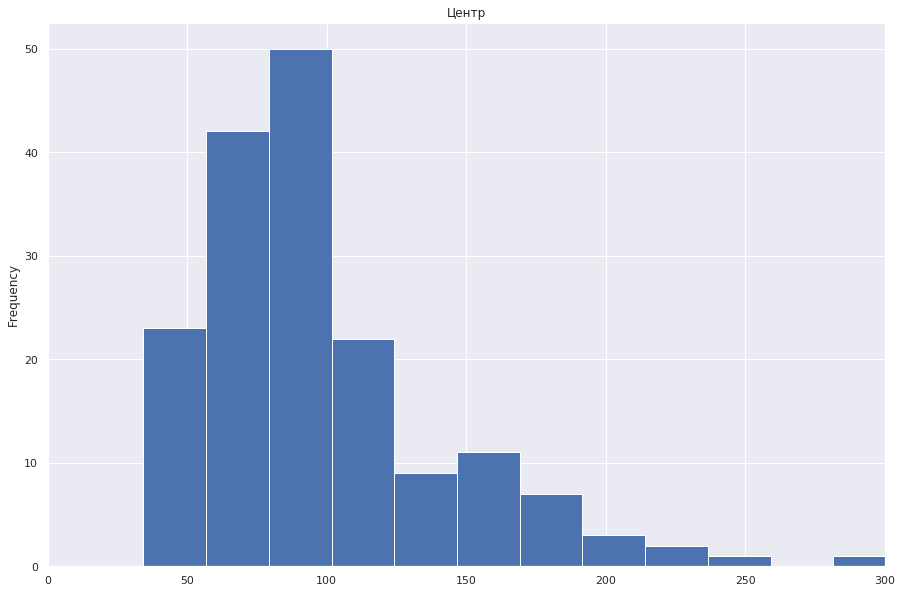

In [38]:
ax = centre_df['total_area'].plot(kind='hist', bins=20, title='Центр', grid=True, xlim=(0,300))

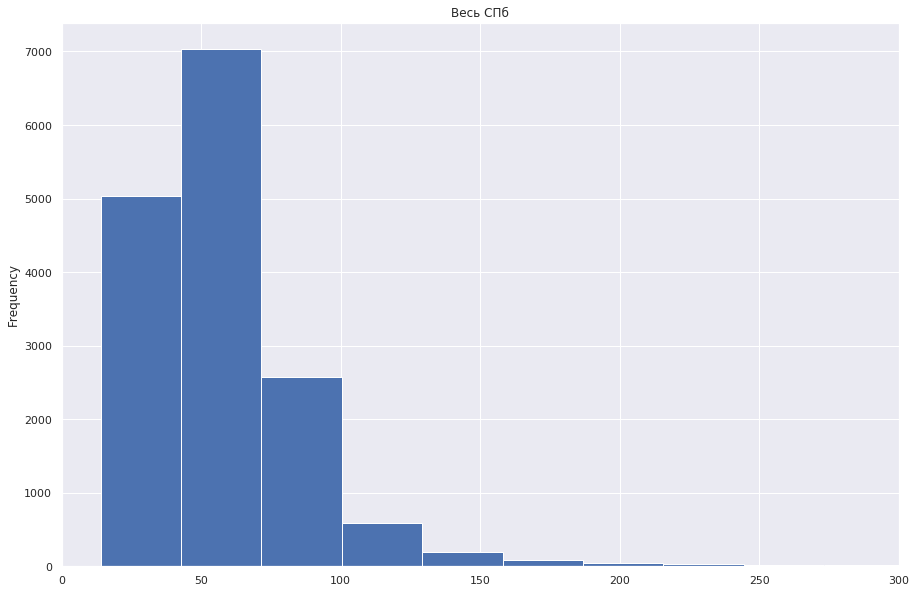

In [39]:
#centre_df['total_area'].plot(kind='hist', bins=20, title='Центр', grid=True, xlim=(0,300))
filtred_df['total_area'].plot(kind='hist', bins=20, title='Весь СПб', grid=True, xlim=(0,300))

Вывод: Квартиры в центре имеют большую площадь чем в среднем по СПб

#### Гистограмма цен на жилье

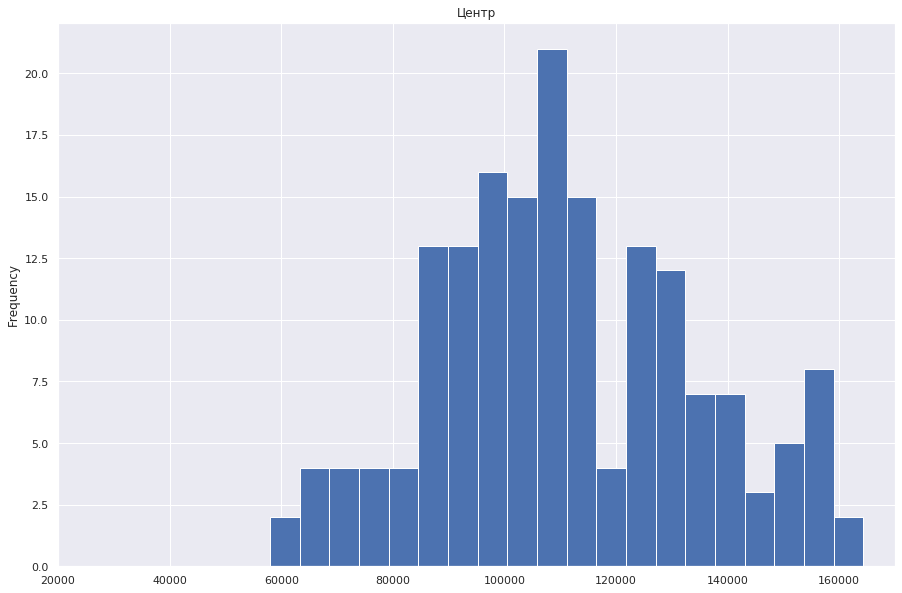

In [40]:
centre_df['square_prise'].plot(kind='hist', bins=20, title='Центр', grid=True, xlim=(20000,170000))

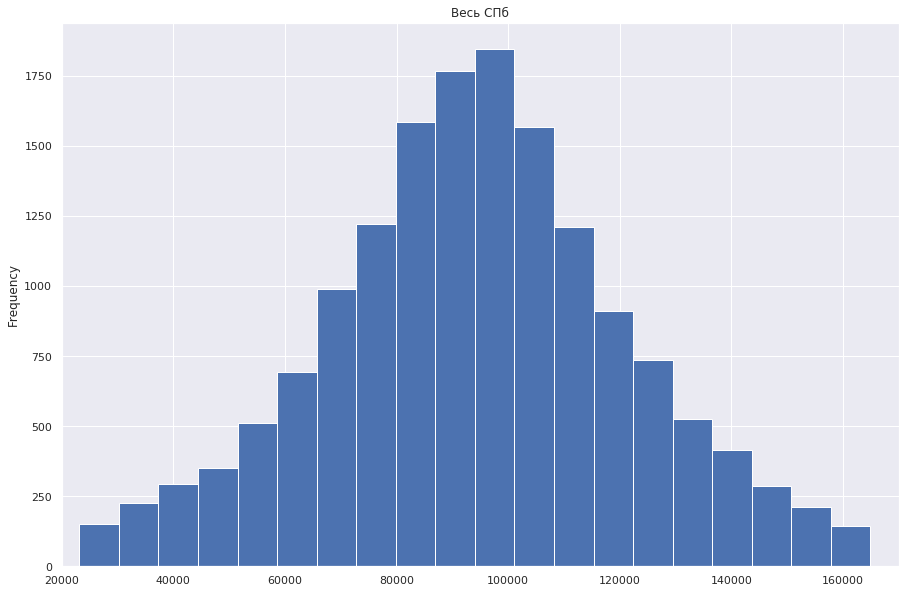

In [41]:
filtred_df['square_prise'].plot(kind='hist', bins=20, title='Весь СПб', grid=True,xlim=(20000,170000))

В центре стоимость квадратного метра начинаеться примерно от 60 тыс.руб., что значительно дороже чем в среднем по СПб, где стоимость квадратного метра начинаться от 20 тыс.руб.


#### Гистограмма количества комнат:

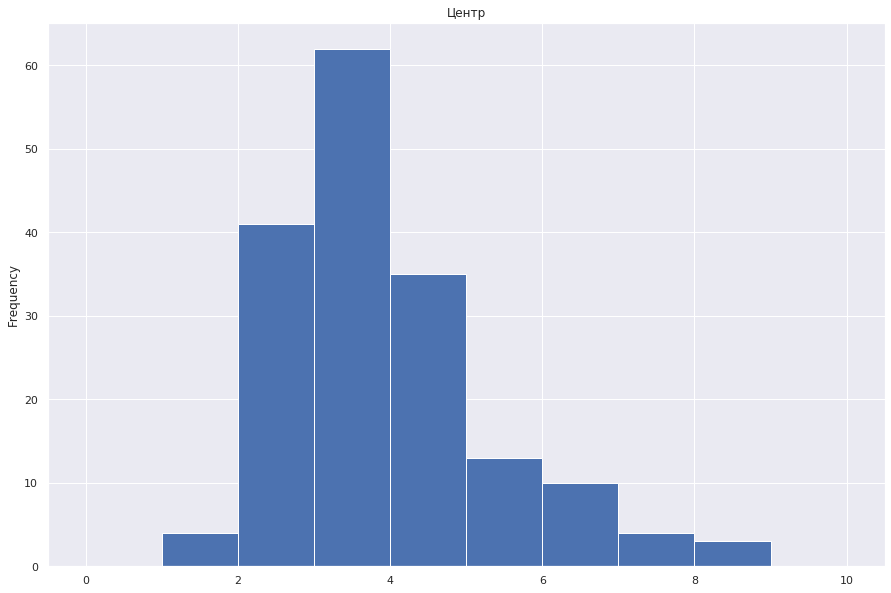

In [42]:
centre_df['rooms'].plot(kind='hist', bins=10, grid=True,  range=(0,10), title='Центр')

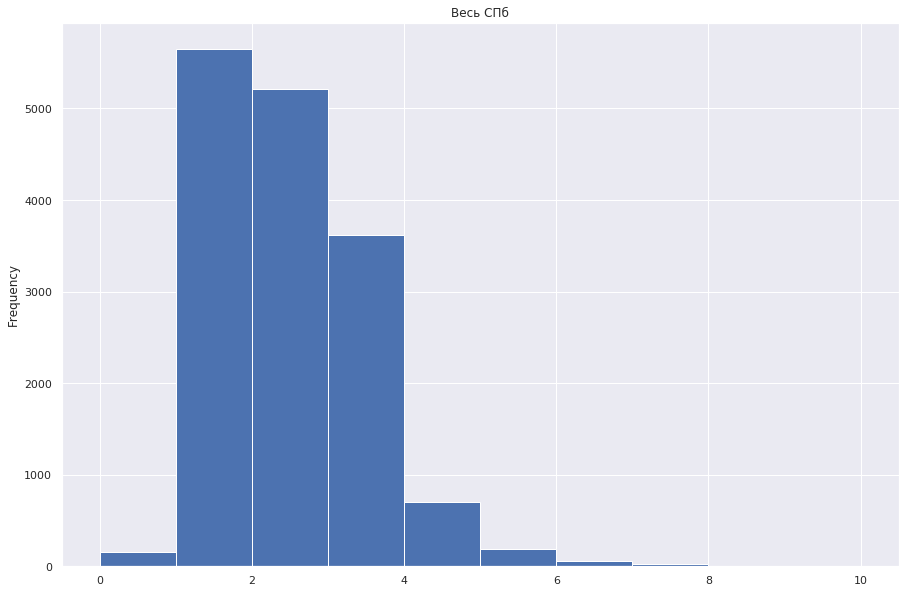

In [43]:
filtred_df['rooms'].plot(kind='hist', bins=10, grid=True,  range=(0,10), title='Весь СПб')

Среднее количество комнат в квартире в центре города и в среднем по СПб, одинаково.


#### Гистограмма высоты потолков:

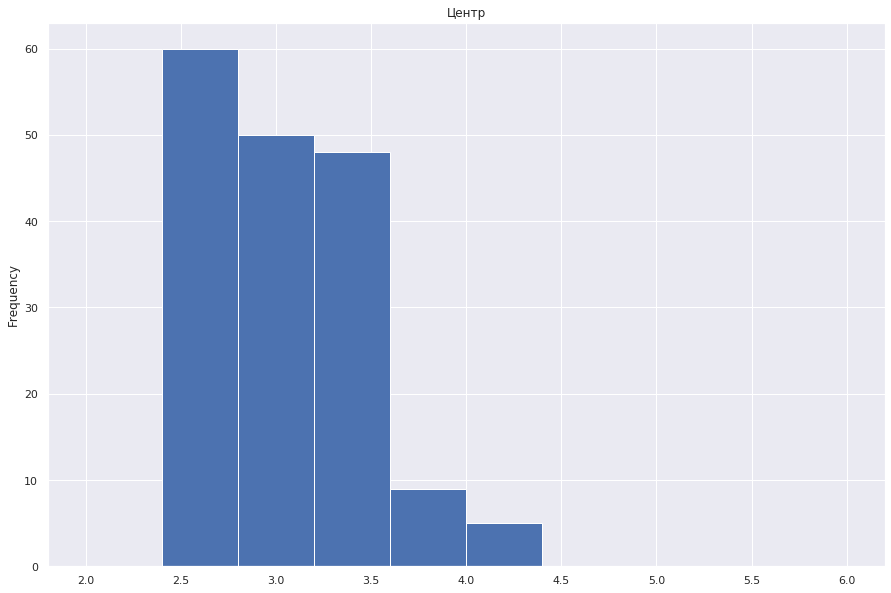

In [44]:
centre_df['ceiling_height'].plot(kind='hist', bins=10, grid=True,  range=(2,6), title='Центр')

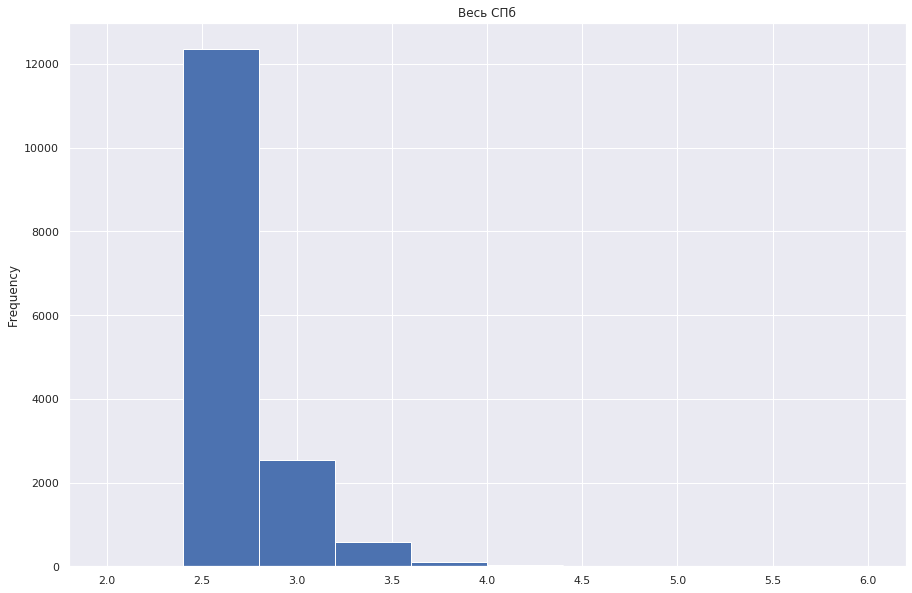

In [45]:
filtred_df['ceiling_height'].plot(kind='hist', bins=10, grid=True,  range=(2,6), title='Весь СПб')

Квартиры в центе часто выше чем в среднем по СПб.

### Гистограма времени продажи квартиры:

Медиана времени продажи квартиры в центре: 172.5
Срднее время продажи квартиры в центре: 280.1860465116279


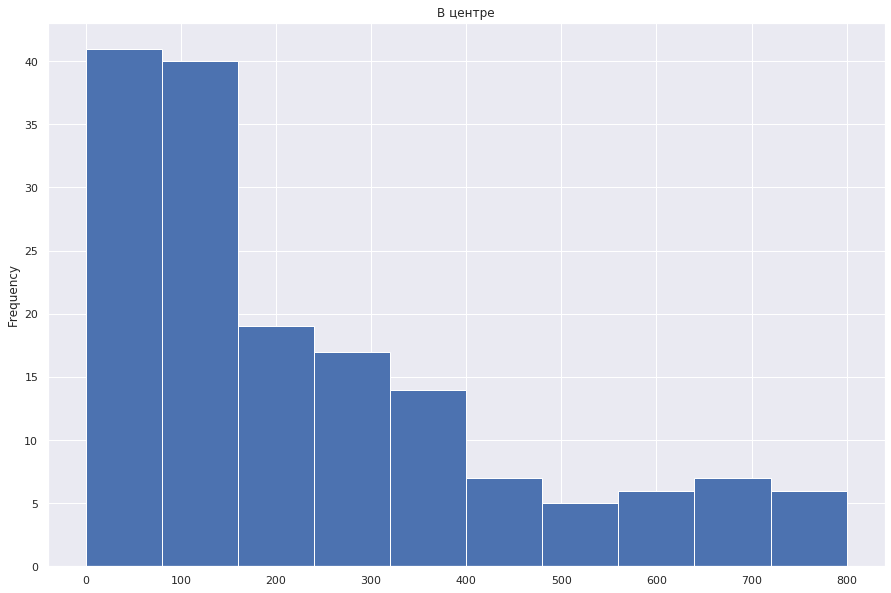

In [46]:
centre_df['days_exposition'].plot(kind='hist', bins=10, grid=True,  range=(0,800), title='В центре')
print('Медиана времени продажи квартиры в центре:', centre_df['days_exposition'].median())
print('Срднее время продажи квартиры в центре:', centre_df['days_exposition'].mean())

Медиана времени продажи квартиры по всему СПб: 97.0
Срднее время продажи квартиры по всему СПб: 182.46925731816438


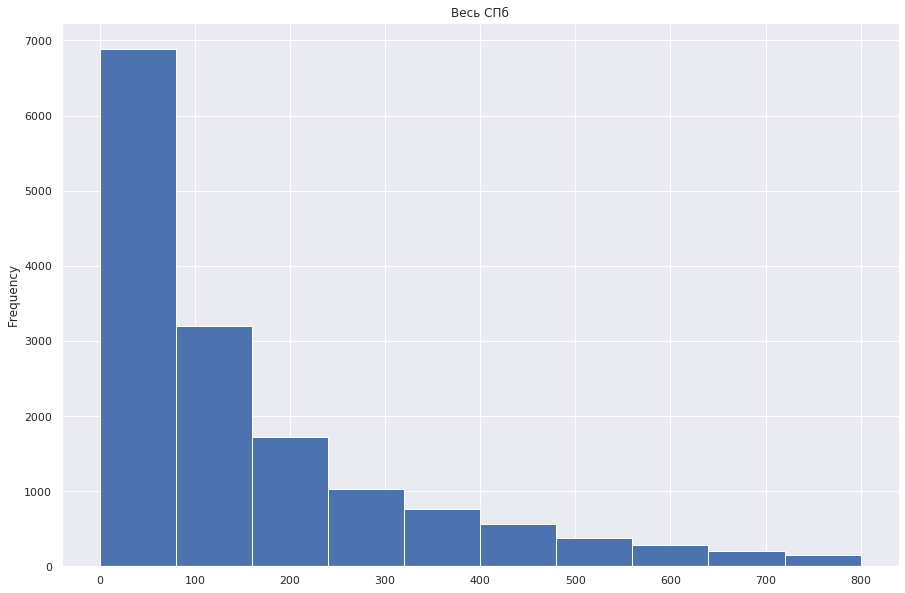

In [47]:
filtred_df['days_exposition'].plot(kind='hist', bins=10, grid=True,  range=(0,800), title='Весь СПб')
print('Медиана времени продажи квартиры по всему СПб:', filtred_df['days_exposition'].median())
print('Срднее время продажи квартиры по всему СПб:', filtred_df['days_exposition'].mean())

Жилье в центральном районе, продается дольше примерно на 22 дня чем в среднем по СПб 

Посмотрим как распределяется гистограмма времени продажи квартиры в первые 14 дней:

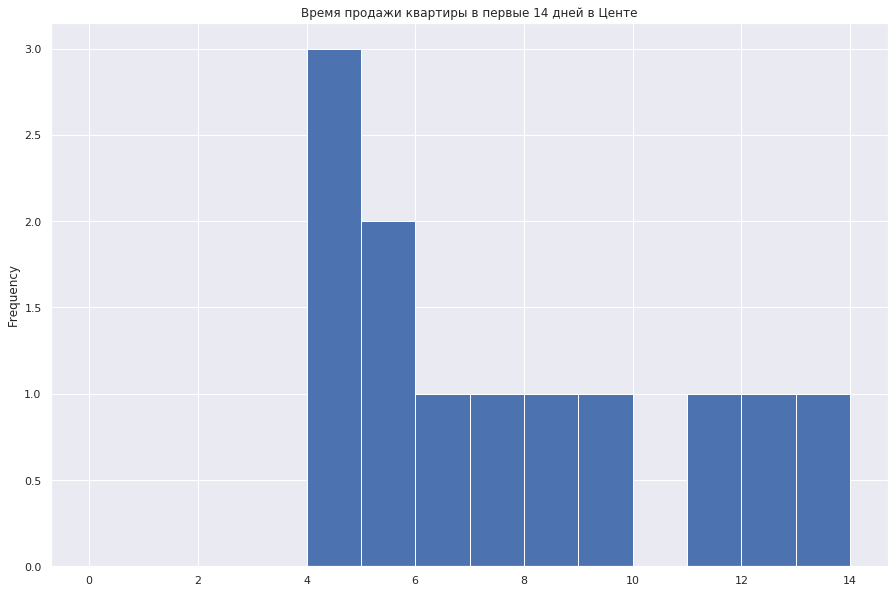

In [48]:
centre_df['days_exposition'].plot(bins=14, range=(0,14), kind='hist', title='Время продажи квартиры в первые 14 дней в Центе')

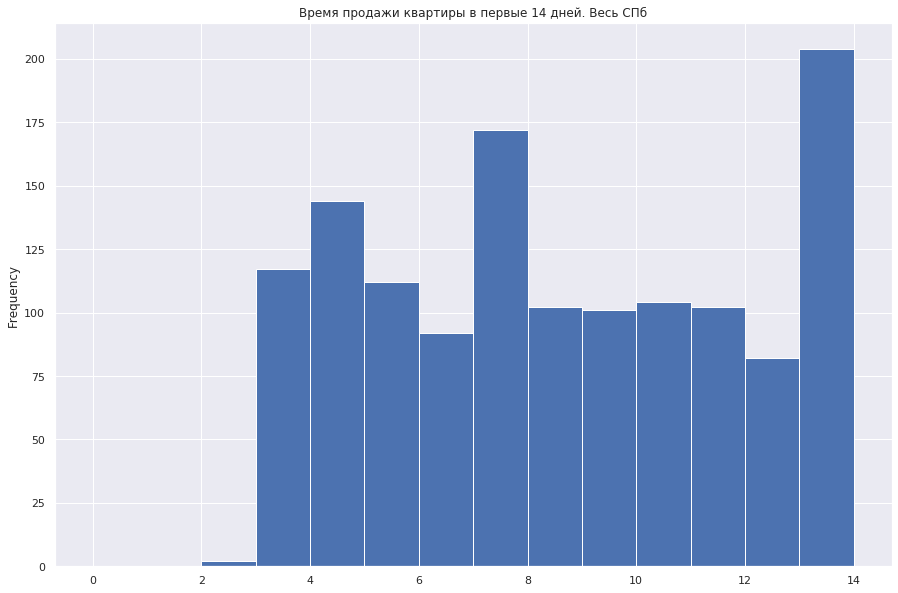

In [49]:
filtred_df['days_exposition'].plot(bins=14, range=(0,14), kind='hist', title='Время продажи квартиры в первые 14 дней. Весь СПб')

В первые 3 суток, продаж практически нет, как для жилья в центральном районе, так и в среднем по СПб

#### Зависимость цены за квадратный метр от общей площади жилья:

Корреляция цены за квадратный метр от общей площади -0.15909111579720178


Text(0, 0.5, 'руб')

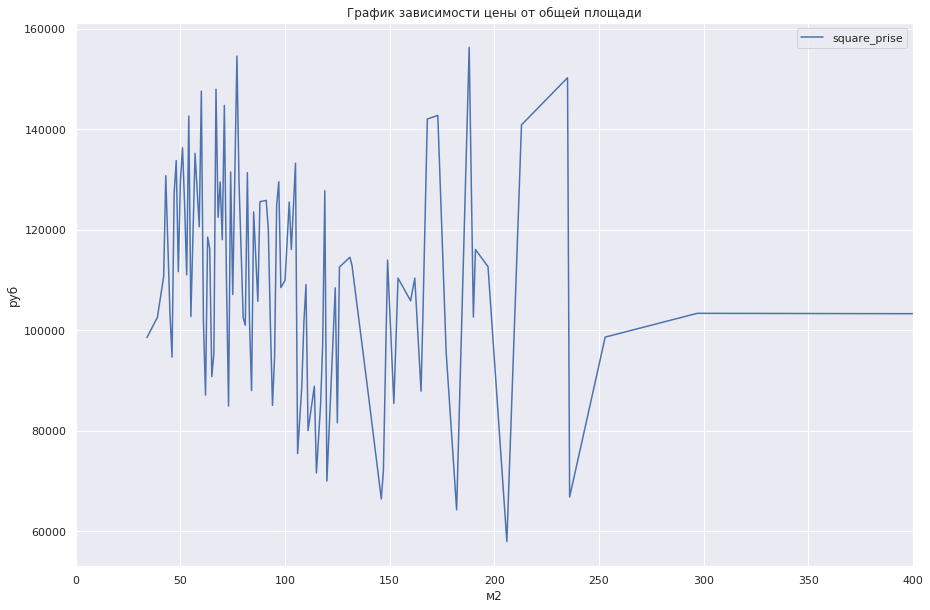

In [50]:
print('Корреляция цены за квадратный метр от общей площади', centre_df['square_prise'].corr(centre_df['total_area']))
centre_df['total_area_round'] = centre_df['total_area'].astype('int')
centre_df.pivot_table(index='total_area_round', values='square_prise',aggfunc='median').plot(title='График зависимости цены от общей площади', xlim=(0,400))
plt.xlabel('м2')
plt.ylabel('руб')

Наблюдается снижение стоимости за квадратный метр в диапазоне с 40 до 120 кв.м., далее идет большой разброс цен.

#### Зависимость цены за квадратный метр от количества комнат:

In [51]:
print('Корреляция цены за квадратный метр от количества комнат', centre_df['square_prise'].corr(centre_df['rooms']))

Корреляция цены за квадратный метр от количества комнат -0.12281904273812184


Посмотрим на распределение количества жилья в зависимости от количества комнат:

In [52]:
centre_df.pivot_table(index='rooms', values='square_prise', aggfunc='count')

,square_prise
rooms,
1,4
2,41
3,62
4,35
5,13
6,10
7,4
8,3


Жилья с количеством комнат до 2 и от 6 мало, поэтому ограничим график промежутком от 2 до 6 комнат:

Text(0, 0.5, 'руб')

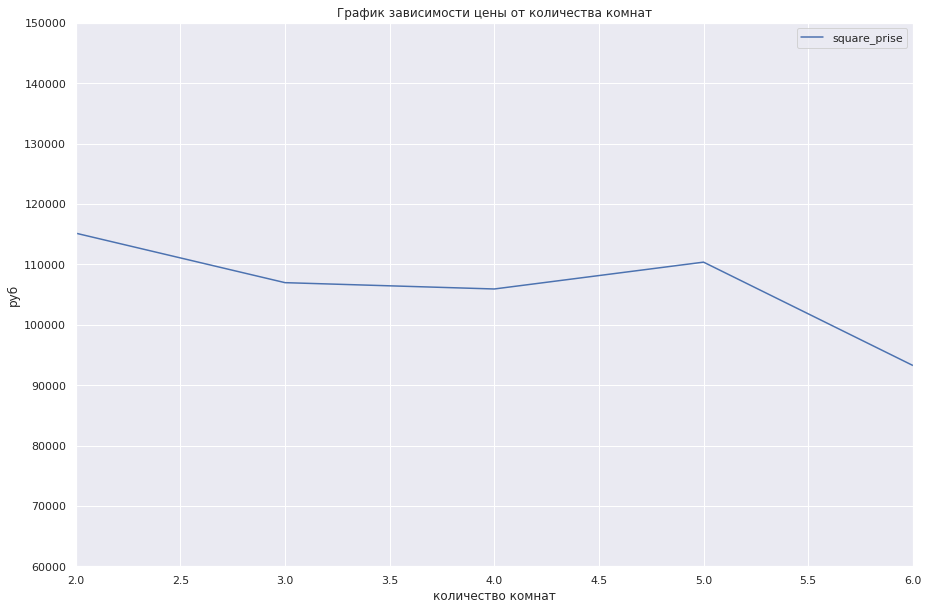

In [53]:
centre_df.pivot_table(index='rooms', values='square_prise',aggfunc='median').plot(title='График зависимости цены от количества комнат', xlim=(2,6), ylim=(60000,150000))
plt.xlabel('количество комнат')
plt.ylabel('руб')

Из графика видно что стоиомсть квадратного метра жилья примерно одинакова для 2-5 комнатных квартир, и значительно ниже для 6 комнатных квартир

#### Зависимость цены за квадратный метр от расстояния до центра:

In [54]:
print('Корреляция цены за квадратный метр от расстояния до центра', centre_df['square_prise'].corr(filtred_df['cityCenters_nearest']))

Корреляция цены за квадратный метр от расстояния до центра -0.11848959533320913


Text(0, 0.5, 'руб')

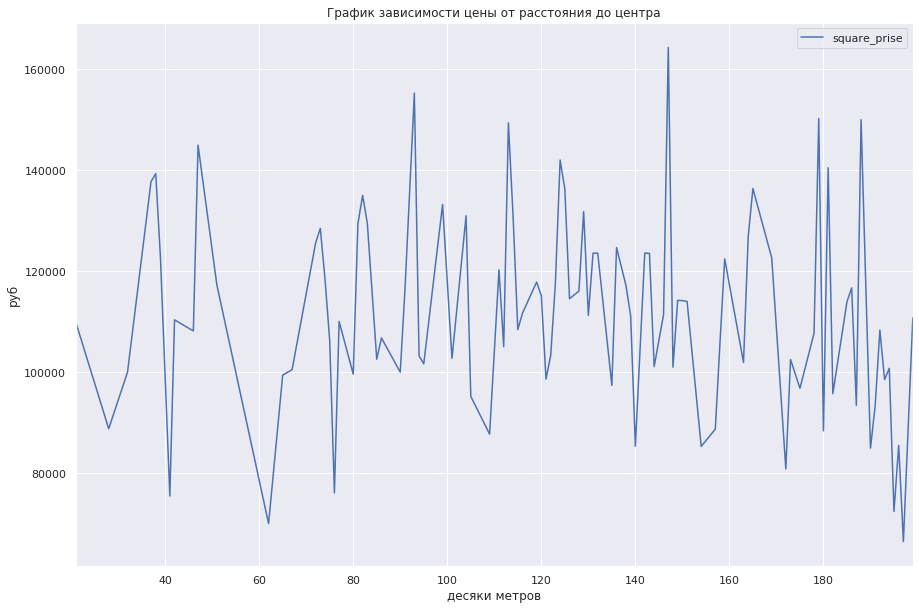

In [55]:
centre_df['cityCenters_nearest_round'] = (centre_df['cityCenters_nearest']/10).astype('int')
centre_df.pivot_table(index='cityCenters_nearest_round', values='square_prise',aggfunc='median').plot(title='График зависимости цены от расстояния до центра')
plt.xlabel('десяки метров')
plt.ylabel('руб')

Зависимость не прослеживается

#### Тепловая карта корреляций всего датафрейма:

Text(0.5, 1, 'Тепловая карта корреляций')

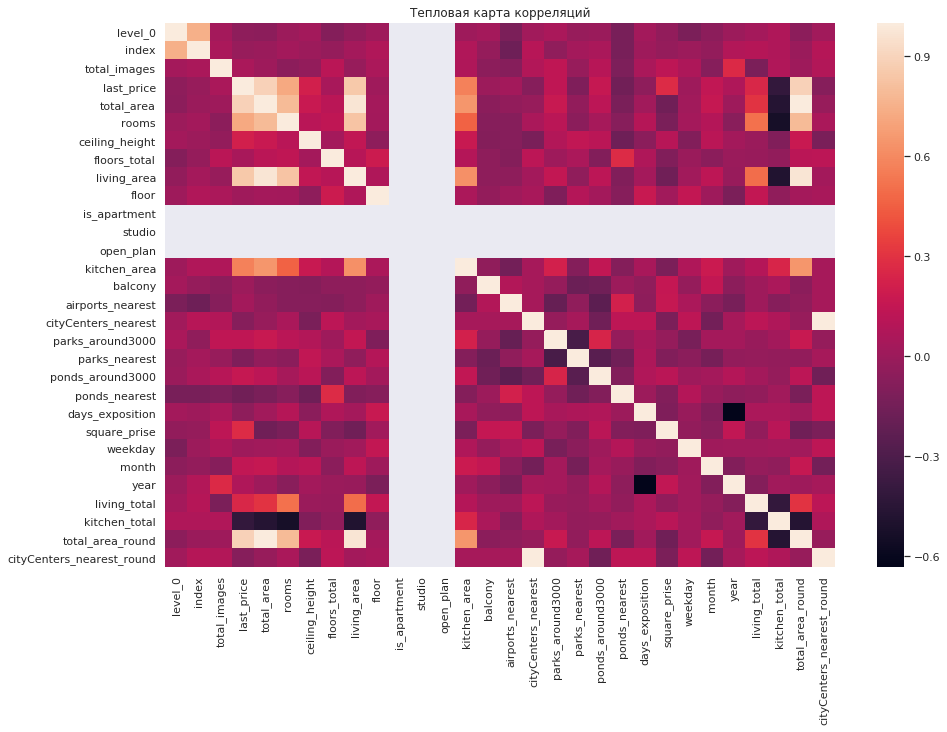

In [56]:
seaborn.set(rc = {'figure.figsize':(15,10)})
ax = plt.axes()
seaborn.heatmap(centre_df.corr())
ax.set_title('Тепловая карта корреляций')

## Общий вывод

- На стоимость жилья в первую очередь влияет удаленность от центра и этаж (не ервый и не последний)
- В первые три дня с момента публикации продажи практически отсутствуют. Вероятно это минимальный период продажи квартиры
- Квартиры редко продают дольше 500 дней
- Есть всплески снятий с публикации объявлений, в периоды кратные 30 дням, что вероятно связано с окончанием подписки
- Квартиры в центральном районе схожы с квартирами в среднем по СПб, по количеству комнат и минимальному сроку продажи жилья
- Квартиры в центре СПб как правило имеют большую общую площадь, выше потолки, выше минимальную стоимость квадратного метра и в срднем продаются дольше на 22 дня чем в среднем жилье по всему СПб.
- В части данных отсутствуют названия населенных пунктов, а некоторые названия написаны по разному. Так как это один из основных параметров, возможно стоит сделать заполнение этого пункта обязательным, а также сделать выпадающий список для выбора населенного пункта.